# Flatiron Data Science - Project 2
## Building a Linear Regression Model<br>Kings County Housing Prices Bakeoff

Khyatee Desai<br>October 23, 2020

# Step 1: Read in Data

In [959]:
import pandas as pd
import numpy as np
from geopy import distance
from geopy import Point
import matplotlib.pyplot as plt
import statistics as stats
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

In [960]:
# read in training dataset
df = pd.read_csv('kc_house_data_train.csv')

# Step 2: Data Cleaning & Outliers

In [961]:
df.isnull().sum().any()

False

In [962]:
df.dtypes

Unnamed: 0         int64
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

### Change date strings to datetime

In [963]:
df['yr_sold'] = pd.to_datetime(df['date'].str.slice(0,8), format='%Y%m%d', errors='ignore').dt.year
df.drop('date',axis=1,inplace=True)

### Check for Outliers

### Drop first two columns because the aren't relevant

In [964]:
df.drop(columns=['Unnamed: 0', 'id'],axis=1,inplace=True)
df.sort_values('price', ascending=False).head(5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_sold
10366,7700000.0,6,8.00,12050,27600,2.5,0,3,4,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800,2014
6903,7062500.0,5,4.50,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449,2014
7519,6885000.0,6,7.75,9890,31374,2.0,0,4,3,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730,2014
2232,5570000.0,5,5.75,9200,35069,2.0,0,0,3,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345,2014
1979,5350000.0,5,5.00,8000,23985,2.0,0,4,3,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750,2015


### Check Baseline Regression R-squared Value

In [1000]:
y = df[['price']]
X = df.iloc[:,1:]
baseline = LinearRegression()
baseline.fit(X,y)
baseline.score(X,y)

0.695493075215057

## Stats Test 1: Waterfront vs. Price
### 2-sample one-tail Welch's T-Test (significance level: 0.05) 
**Rationale:** Comparing the means of two independent samples<br>
**Ho:** Houses on a waterfront sell for the same amount on average as houses not on a waterfront.<br>
**Ha:** Houses on a waterfront sell for more on average than houses not on a waterfront.

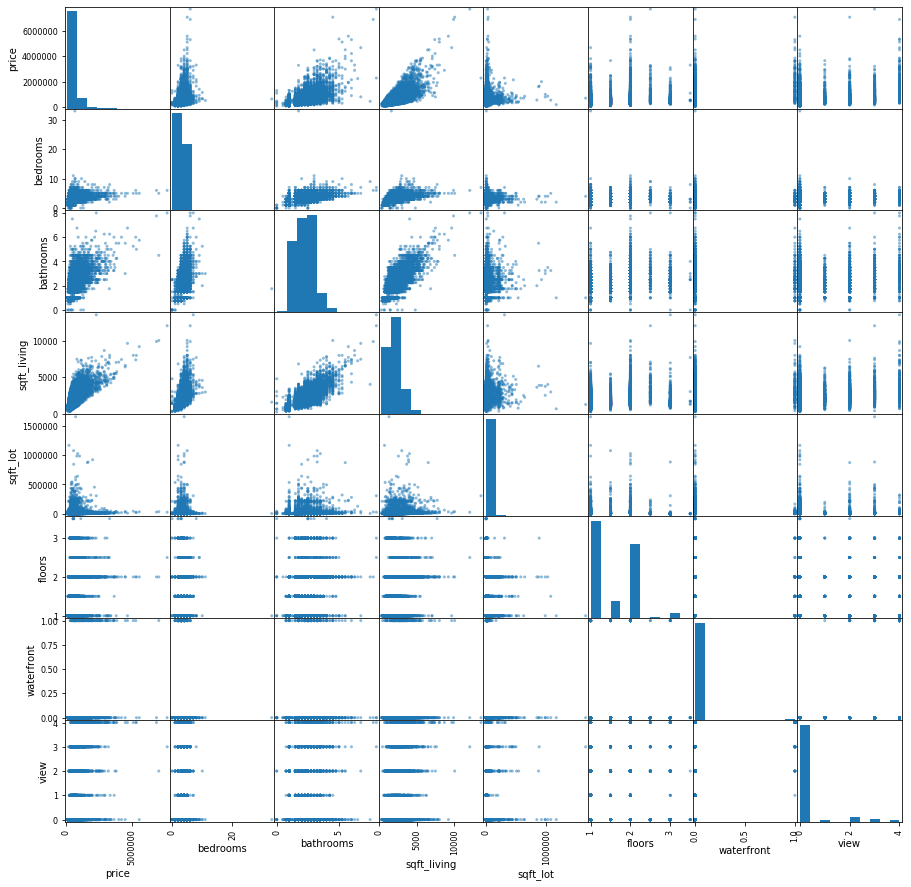

In [966]:
pd.plotting.scatter_matrix(df.iloc[:,:8], figsize= [15,15]);

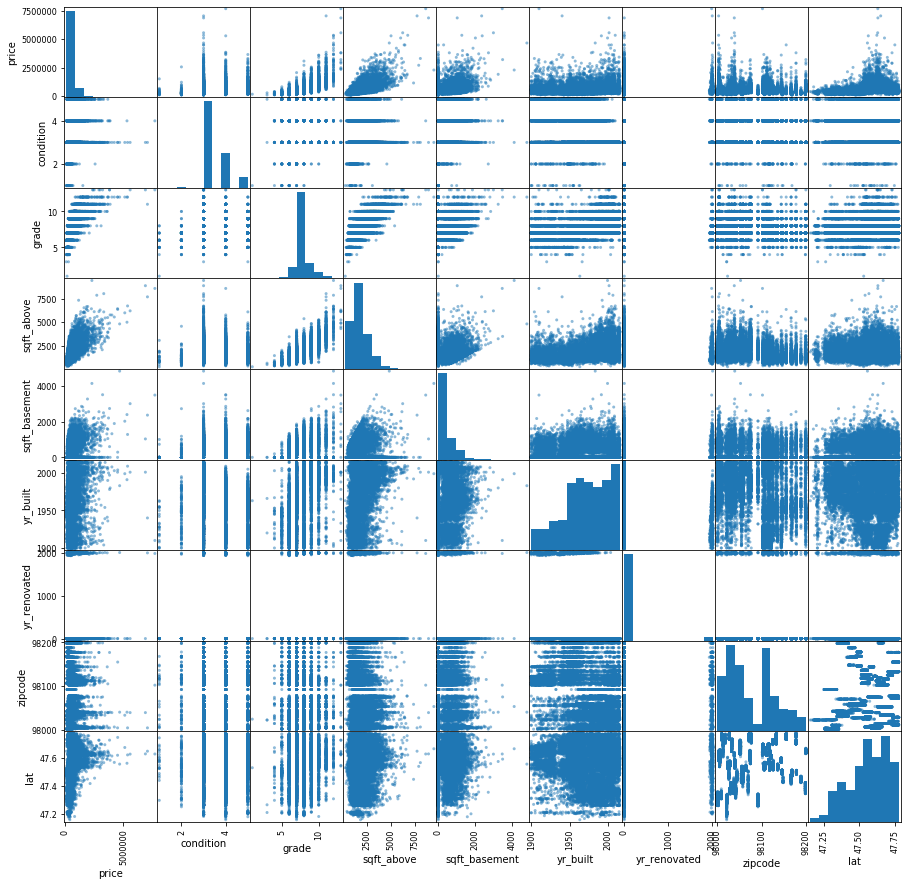

In [967]:
df2 = pd.concat([df['price'],df.iloc[:,8:16]], axis=1)
pd.plotting.scatter_matrix(df2, figsize= [15,15]);

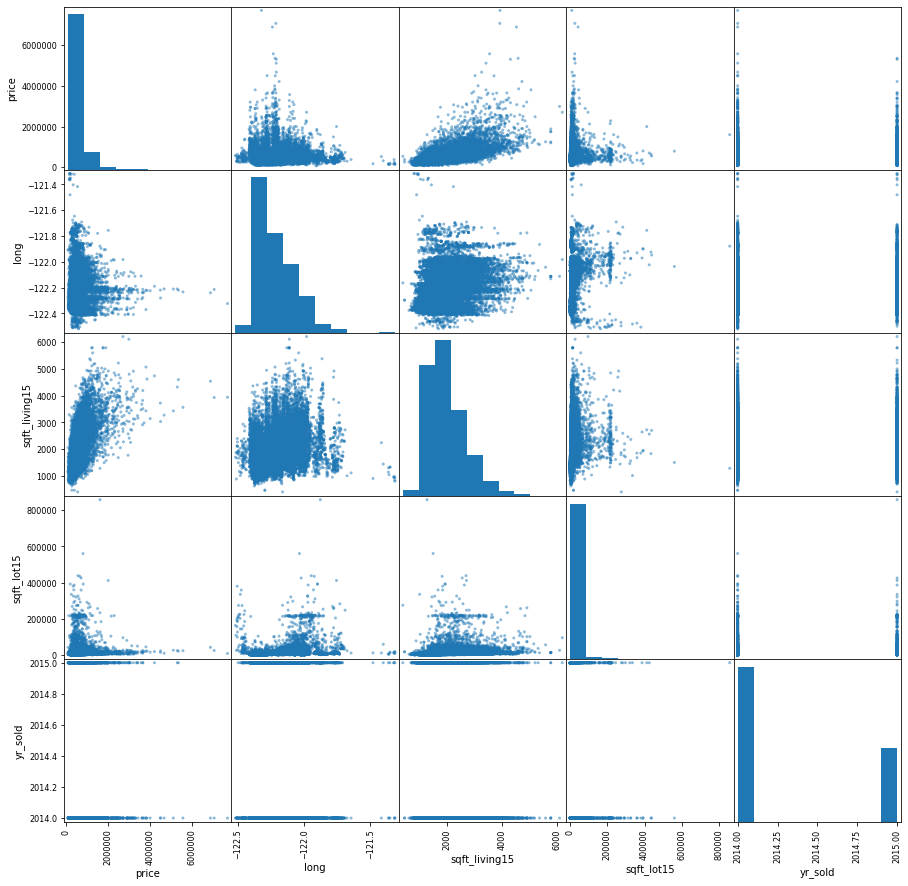

In [968]:
df3 = pd.concat([df['price'],df.iloc[:,16:]], axis=1)
pd.plotting.scatter_matrix(df3, figsize= [15,15]);

# Step 3: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  
Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

- **Exploratory Data Analysis (EDA)**: You must create at least 4 data visualizations that help to explain the data. These visualizations should help someone unfamiliar with the data understand the target variable and the features that help explain that target variable.
- **Statistical Tests**: Your notebook must show at least 3 statistical tests that you preformed on your data set. Think of these as being part of your EDA process; for example, if you think houses with a view cost more than those without a view, then perform a two-sample T-test. These can be preliminary evidence that a feature will be important in your model.


In [969]:
# create the samples from main dataframe
waterfront = df[df['waterfront']==1]
no_waterfront = df[df['waterfront']==0]

# Check assumptions
print(stats.variance(waterfront.price))
print(stats.variance(no_waterfront.price))

1302710157270.6848
119397859838.78746


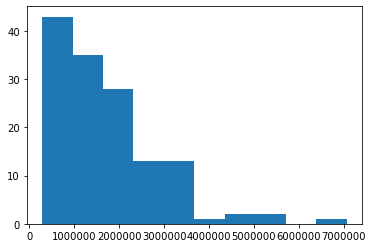

In [970]:
plt.hist(waterfront.price);

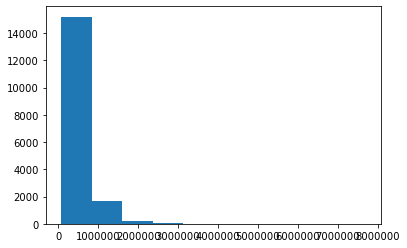

In [971]:
plt.hist(no_waterfront.price);

In [972]:
# perform welch's t-test (two-tailed by default)
welch = scipy.stats.ttest_ind(waterfront.price, no_waterfront.price, equal_var=False)
print('p-value:',welch[1]/2)

p-value: 3.470220628045268e-23


### P-value is 3.47e-23, which is lower than 0.05 alpha, indicating we can reject the null hypothesis in favor of the alternative, that houses on a waterfront sell for more on average than houses not on a waterfront.

## Stats Test 2: Zip Code vs. Price
### ANOVA Test
**Rationale:** Comparing means of several independent samples<br>
**Ho:** There is no difference in the average price of houses in different zip codes.<br>
**Ha:** Houses in different zip codes have different average house prices.

In [973]:
# Concatenate zipcode dummy variables with with main dataframe
X_dummies = pd.concat([df['price'], zip_dummies], axis=1)
formula = "price ~ "+ '+'.join(list(zip_dummies.columns))
model = ols(formula, X_dummies).fit()
table = sm.stats.anova_lm(model, typ=2)
table.sort_values('PR(>F)').head(10)

,sum_sq,df,F,PR(>F)
zip98039,1.349927e+14,1.0,1611.813889,0.000000e+00
zip98004,1.605789e+14,1.0,1917.312755,0.000000e+00
zip98040,1.029211e+14,1.0,1228.878990,4.127097e-260
zip98112,8.604568e+13,1.0,1027.385948,5.199502e-219
zip98006,5.262880e+13,1.0,628.388162,3.075398e-136
zip98033,4.278113e+13,1.0,510.806899,1.763268e-111
zip98075,3.735075e+13,1.0,445.968136,9.416298e-98
zip98105,3.661641e+13,1.0,437.200116,6.829872e-96
zip98199,3.504893e+13,1.0,418.484416,6.444296e-92
zip98119,3.393523e+13,1.0,405.186836,4.325909e-89


### _____________interpretation here ___________

## Stats Test 3: ___ vs ___
### ____ Test
**Rationale:** Comparing means of several independent samples<br>
**Ho:** There is no difference in the average price of houses in different zip codes.<br>
**Ha:** Houses in different zip codes have different average house prices.

# Step 4: Feature Engineering

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.
- **Feature Engineering**: You must create at least 3 new features to test in your model. Those features do not have to make it into your final model, as they might be removed during the feature selection process. That is expected, but you still need to explain the features you engineer and your thought process behind why you thought they would explain the selling price of the house.

## Zipcode Dummy Variables

In [1001]:
# Create dummy variables for zip code 
zip_dummies = pd.get_dummies(df['zipcode'].astype(str), dtype=int, drop_first=True)
df.drop(columns=['zipcode'],inplace=True)
new_cols = 'zip'+zip_dummies.columns
zip_dummies.columns = new_cols
zip_dummies.head()

KeyError: 'zipcode'

## House Years Old 

In [1002]:
# Create yrs_old column
yrs_old = df['yr_sold']- df['yr_built']

## Distance from City 
Distance (miles) from each house to Pikes Place Market (essentially downtown seattle)

In [1003]:
distances=[]
for (lat, long) in list(zip(df['lat'],df["long"])):
    p1 = Point(f'{lat} {long}')
    pikes_place = Point("47.6086 -122.3401")
    distances.append(distance.distance(p1,pikes_place).miles)

Add new features to a dataframe, run model

In [1004]:
# add new features to dataframe, concat with main dataframe
new_features = pd.DataFrame()
new_features['yrs_old'] = yrs_old
new_features['miles_from_city'] = distances
y = df[['price']]
X_feat = pd.concat([df.iloc[:,1:], new_features, zip_dummies], axis=1)

# run model with new features included
lr = LinearRegression()
lr.fit(X_feat,y)
lr.score(X_feat,y)

0.807370566869925

## Interaction Features

Get R-squared for interactions between every possible feature combination

In [1005]:
# Generate combinations of features
interactions = list(combinations(X.columns, 2))
interaction_dict = {}

for interaction in interactions:
    X_copy = X.copy()
    X_copy['interact'] = X_copy[interaction[0]] * X_copy[interaction[1]]  
    model = LinearRegression() #run model with each possible interaction
    model.fit(X_copy, y)
    interaction_dict[model.score(X_copy, y)] = interaction # add R-squared for each interaction to a dictionary
sorted(interaction_dict.items(), reverse = True)[:5]

[(0.7411036287397502, ('sqft_living', 'grade')),
 (0.7311905327256875, ('bathrooms', 'grade')),
 (0.7285769065988821, ('sqft_living', 'sqft_above')),
 (0.7278897367885899, ('bathrooms', 'sqft_living')),
 (0.7266347679330285, ('grade', 'sqft_above'))]

### Add best 20 interactions to model

In [1006]:
interaction_df = X.copy()
top_interactions = sorted(interaction_dict.keys(), reverse = True)[:20]

for interaction in top_interactions:
    feature1 = interaction_dict[interaction][0]
    feature2 = interaction_dict[interaction][1]
    interaction_df[feature1+'_X_'+feature2] = interaction_df[feature1] * interaction_df[feature2]
    new_features[feature1+'_X_'+feature2] = interaction_df[feature1] * interaction_df[feature2] #also add to new_features df
    model = LinearRegression() # run model with each added interaction term
    model.fit(interaction_df, y)
    r_squared = model.score(interaction_df, y)
    print('R-Squared is',r_squared,'after adding:  ',feature1+'_X_'+feature2)

R-Squared is 0.7411036287397502 after adding:   sqft_living_X_grade
R-Squared is 0.741393776918352 after adding:   bathrooms_X_grade
R-Squared is 0.7415755208212822 after adding:   sqft_living_X_sqft_above
R-Squared is 0.7416427192517191 after adding:   bathrooms_X_sqft_living
R-Squared is 0.7442473071740885 after adding:   grade_X_sqft_above
R-Squared is 0.7446281368458726 after adding:   bathrooms_X_sqft_above
R-Squared is 0.7446281368458718 after adding:   grade_X_sqft_basement
R-Squared is 0.744802086644826 after adding:   sqft_above_X_sqft_basement
R-Squared is 0.746272853527546 after adding:   sqft_living_X_sqft_living15
R-Squared is 0.7480123358318793 after adding:   sqft_living_X_view
R-Squared is 0.7562191209632279 after adding:   sqft_living_X_waterfront
R-Squared is 0.7578322356412006 after adding:   sqft_living_X_sqft_basement
R-Squared is 0.7580148251439258 after adding:   view_X_sqft_above
R-Squared is 0.7581891481598811 after adding:   view_X_grade
R-Squared is 0.7595881

## Log Transformations

In [1007]:
# generate new features for logs of non-normal features (based on histograms)
non_normal = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot15']
for feat in non_normal:
    new_features['log_'+feat] = df[feat].map(lambda x: np.log(x))
new_features = new_features.replace([np.inf, -np.inf], 0)
new_features.head()

/Users/Khyatee/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


,yrs_old,miles_from_city,sqft_living_X_grade,bathrooms_X_grade,sqft_living_X_sqft_above,bathrooms_X_sqft_living,grade_X_sqft_above,bathrooms_X_sqft_above,grade_X_sqft_basement,sqft_above_X_sqft_basement,...,log_bedrooms,log_bathrooms,log_sqft_living,log_sqft_lot,log_floors,log_condition,log_grade,log_sqft_above,log_sqft_living15,log_sqft_lot15
0,28,14.389780,16560,18.0,4284900,4657.5,16560,4657.5,0,0,...,1.386294,0.810930,7.635304,9.093020,0.693147,1.386294,2.079442,7.635304,7.779049,8.948976
1,37,5.465502,23200,24.0,5307000,8700.0,14640,5490.0,8560,1958100,...,1.609438,1.098612,7.972466,8.814330,0.000000,1.609438,2.079442,7.512071,7.770645,8.745603
2,17,10.324296,41470,27.5,14212900,9425.0,41470,9425.0,0,0,...,1.386294,0.916291,8.234830,9.295876,0.693147,1.098612,2.397895,8.234830,8.218787,9.178334
3,25,8.174302,54720,42.0,20793600,15960.0,54720,15960.0,0,0,...,1.098612,1.252763,8.425078,9.589325,0.693147,1.098612,2.484907,8.425078,8.306472,9.562827
4,10,12.615314,22950,22.5,6502500,6375.0,22950,6375.0,0,0,...,1.098612,0.916291,7.843849,8.589700,0.693147,1.098612,2.197225,7.843849,7.718685,8.306472


### Run model with new features, interactions, log transformations, and dummy variables included

In [1008]:
y = df[['price']]
X_logs = pd.concat([df.iloc[:,1:], new_features, zip_dummies], axis=1)

# run model with log features included
lr = LinearRegression()
lr.fit(X_logs,y)
lr.score(X_logs,y)

0.8609390023719707

## Polynomial Features¶

In [1009]:
non_normal = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_living15', 'sqft_lot15']
for feat in non_normal:
    new_features[feat+'^2'] = df[feat]**2
    new_features[feat+'^3'] = df[feat]**3
new_features.head()

,yrs_old,miles_from_city,sqft_living_X_grade,bathrooms_X_grade,sqft_living_X_sqft_above,bathrooms_X_sqft_living,grade_X_sqft_above,bathrooms_X_sqft_above,grade_X_sqft_basement,sqft_above_X_sqft_basement,...,condition^2,condition^3,grade^2,grade^3,sqft_above^2,sqft_above^3,sqft_living15^2,sqft_living15^3,sqft_lot15^2,sqft_lot15^3
0,28,14.389780,16560,18.0,4284900,4657.5,16560,4657.5,0,0,...,16,64,64,512,4284900,8869743000,5712100,13651919000,59290000,456533000000
1,37,5.465502,23200,24.0,5307000,8700.0,14640,5490.0,8560,1958100,...,25,125,64,512,3348900,6128487000,5616900,13312053000,39476089,248028267187
2,17,10.324296,41470,27.5,14212900,9425.0,41470,9425.0,0,0,...,9,27,121,1331,14212900,53582633000,13764100,51064811000,93799225,908445494125
3,25,8.174302,54720,42.0,20793600,15960.0,54720,15960.0,0,0,...,9,27,144,1728,20793600,94818816000,16402500,66430125000,202379076,2879044735176
4,10,12.615314,22950,22.5,6502500,6375.0,22950,6375.0,0,0,...,9,27,81,729,6502500,16581375000,5062500,11390625000,16402500,66430125000


### Run model with new features, interactions, log transformations, polynomials, and dummy variables

In [1010]:
y = df[['price']]
X_poly = pd.concat([df.iloc[:,1:], new_features, zip_dummies], axis=1)

# run model with log features included
lr = LinearRegression()
lr.fit(X_poly,y)
lr.score(X_poly,y)

0.7111082831866278

## Look at Multicollinearity

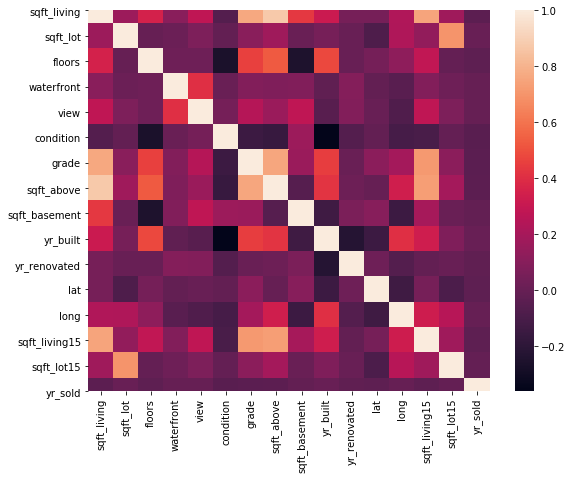

In [982]:
plt.figure(figsize=[9,7]);
sns.heatmap(df.iloc[:,3:].corr());

### Use stacking to look at feature pairs with highest correlations

In [983]:
corr=df.iloc[:,3:].corr().abs().stack().reset_index().sort_values(0, ascending=False)
corr['pairs'] = list(zip(corr.level_0, corr.level_1))
corr.drop(columns=['level_1', 'level_0'], inplace = True)
corr.columns = ['correlation', 'pairs']
corr.drop_duplicates(inplace=True)
corr[(corr.correlation >0.75) & (corr.correlation <1.0)]

,correlation,pairs
112,0.876696,"(sqft_above, sqft_living)"
7,0.876696,"(sqft_living, sqft_above)"
6,0.762929,"(sqft_living, grade)"
96,0.762929,"(grade, sqft_living)"
118,0.758247,"(sqft_above, grade)"
103,0.758247,"(grade, sqft_above)"
208,0.755066,"(sqft_living15, sqft_living)"
13,0.755066,"(sqft_living, sqft_living15)"


### Check Variance Inflation Factor (VIF) Scores

In [984]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

predictors= df.iloc[:,3:]
predictors['Intercept']=1.0
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif["features"] = predictors.columns
vif.sort_values('VIF',ascending=False).head(10)

/Users/Khyatee/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,features
0,inf,sqft_living
7,inf,sqft_above
8,inf,sqft_basement
16,2.007091e+07,Intercept
6,3.359214e+00,grade
13,2.943656e+00,sqft_living15
9,2.094802e+00,yr_built
14,2.034006e+00,sqft_lot15
1,2.003948e+00,sqft_lot
2,1.854139e+00,floors


### Impact of removing multicollinear variables

In [985]:
y = df[['price']]
X = df.iloc[:,1:]
X.drop(columns=['sqft_living'], inplace=True) # barely impacts R-squared, so dropping it.
dropMultico = LinearRegression()
dropMultico.fit(X,y)
dropMultico.score(X,y)

0.6954930752150568

# Step 5: Train-Test Split 


### 5.1) Perform a train-test split of the data.

In [1011]:
X_all = pd.concat([df.iloc[:,1:],new_features, zip_dummies], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 5.2) Fit your scaler to training the data.

### 5.3) Transform the testing set with the scaler.

### 5.4) Fit the model to the training data.

In [1012]:
model_1 = LinearRegression()
model_1.fit(X_train, y_train)
model_1.score(X_train, y_train)

0.6945181689796693

In [1013]:
model_1.score(X_test, y_test)

0.6991972173001545

### 5.5) Use the model to predict on the training set and the test set.

In [1014]:
y_train_pred = model_1.predict(X_train)
y_test_pred = model_1.predict(X_test)

### 5.6) Evaluate the training and test predictions using RMSE.

In [1015]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_train, y_train_pred))

207478.81807140211

In [1016]:
np.sqrt(mean_squared_error(y_test, y_test_pred))


200059.58979252056

### 5.7) Determine if your model is overfit.

In [992]:
#your code here 

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models.
- **Feature Selection** - There are many ways to do feature selection: filter methods, P-values, or recursive feature elimination (RFE). You should try multiple different techniques and combinations of them. For your final model, you will settle on a process of feature selection; this process should be clearly shown in your final notebook.


### 6.1) Utilize a filter method to identify some features to remove from the model.  

In [7]:
# your code here

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

In [8]:
# your code here

## Step 7: Evaluate your different models in order to determine the best model overall.
- Model Interpretation: One of the benefits of a linear regression model is that you can interpret the coefficients of the model to derive insights. For example, which feature has the biggest impact on the price of the house? Was there a feature that you thought would be significant but was not? Think if you were a real estate agent helping clients price their house: what information would you find most helpful from this model?

## Step 8:  Refit your best model to the entire dataset.

## Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/